In [1]:
import time
import random
import datetime
from collections import defaultdict

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (
    Conv2D, BatchNormalization, Dropout, MaxPool2D,
    Flatten, Dense, Input, Concatenate, LeakyReLU, Add
)

# LOAD LIBRARIES
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
#from tf.keras.utils.np_utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import LearningRateScheduler

# How to check if Keras is using GPU?

#from tf.keras import backend as K

#K.tensorflow_backend._get_available_gpus()

train = pd.read_csv('./data/train.csv')
test  = pd.read_csv('./data/test.csv')
submission = pd.read_csv('./data/submission.csv')

In [8]:
X_train = (train[[str(i) for i in range(784)]] / 255.).values.reshape(-1, 28, 28, 1)
y_train = tf.keras.utils.to_categorical(train['digit'].values)

In [10]:
# 아마 성능 향상의 가장 큰 요인, 데이터 증강
# CREATE MORE IMAGES VIA DATA AUGMENTATION
datagen = ImageDataGenerator(
        rotation_range=10,  
        zoom_range = 0.10,  
        width_shift_range=0.1, 
        height_shift_range=0.1)

In [20]:
# Create the base model from the pre-trained model VGG16
model = Sequential()
model.add(Conv2D(32, kernel_size = 3, activation='relu', input_shape = (28, 28, 1)))
model.add(Conv2D(32, kernel_size = 3, activation='relu'))
model.add(Conv2D(32, kernel_size = 5, strides=2, padding='same', activation='relu'))
model.add(Dropout(0.4))

model.add(Conv2D(64, kernel_size = 3, activation='relu'))
model.add(Conv2D(64, kernel_size = 3, activation='relu'))
model.add(Conv2D(64, kernel_size = 5, strides=2, padding='same', activation='relu'))
model.add(Dropout(0.4))

model.add(Conv2D(128, kernel_size = 4, activation='relu'))
model.add(Flatten())
model.add(Dropout(0.4))
model.add(Dense(10, activation='softmax'))


In [21]:
annealer = LearningRateScheduler(lambda x: 1e-3 * 0.95 ** x)

In [35]:
print(X_train.shape)
print(y_train.shape)

(2048, 28, 28, 1)
(2048, 10)


In [36]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Nadam(lr=base_learning_rate),
              loss=tf.keras.losses.categorical_crossentropy,
              metrics=['accuracy'])

In [37]:
epochs = 45
# Train-Test를 9:1로 분리
X_train2, X_val2, y_train2, y_val2 = train_test_split(X_train, y_train, test_size = 0.1)

history = model.fit(
    datagen.flow(X_train2, y_train2, batch_size=32),
    epochs=epochs, 
    batch_size=32,
    validation_batch_size=32,
    steps_per_epoch=X_train2.shape[0]//32,
    validation_data=(X_val2, y_val2), 
    callbacks=[annealer], 
    verbose=0
)

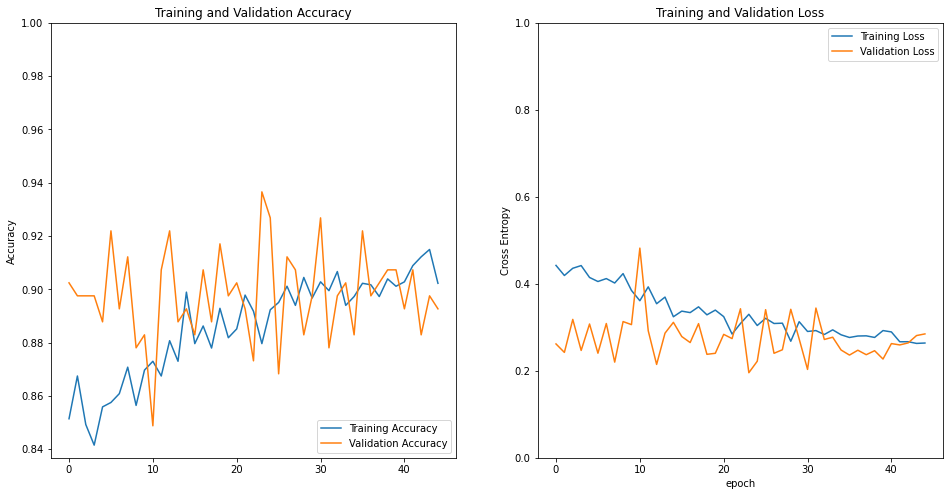

In [38]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
# Parameter 및 모델 구조 저장
model.save_weights(f'params.h5')
    
model_json = model.to_json()
with open(f"model.json", "w") as json_file : 
    json_file.write(model_json)